# TO DO STILL
- RUNS ALL GRAPHS (& fix minor stuff if needed)
- analysis of each graph
- trier graphs
- remove magic values

# **ADApocalypse present :** "What do we do now ?"

## Project Initialisation

### Import libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
import json
from collections import defaultdict
#from transformers import pipeline
import ast
import re
import plotly.express as px
import plotly.graph_objects as go

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.preprocessing import StandardScaler
# from statsmodels import tools
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier, plot_tree
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# import folium
# import geopandas as gpd
# from folium import Choropleth, CircleMarker, Popup

# not displaying warnings
pd.options.mode.chained_assignment = None 

# to facilitate the use of py files
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from src.data.data_loader import *
from src.data.data_transformer import *
from src.utils.visualization import *
from src.utils.methods import *

### Constants

In [ ]:
COLOR_MALE = '#2D9884'
COLOR_FEMALE = '#6E17C6'
COLOR_MALE_LIGHT = '#17D07D'
COLOR_FEMALE_LIGHT = '#B56BEA'
COLOR_NEUTRAL = '#2D9884'
COLOR_PALETTE = {'M': COLOR_MALE, 'F': COLOR_FEMALE}

# 1. Loading file

We processed the data of each dataframe (detail in src/data/data_transformer) and computed the following functions once in order to generate the csv file :
- preprocess_movie_metadata()
- preprocess_char_metadata()
- preprocess_imdb_ratings(movies_metadata_df)
- preprocess_plot_emotions()

We applied the following rules to filter and preprocess the files: 
- all movies without release date were dropped
- all movies with a release date outside of the range 1910-2013 were dropped
- the release date were standardized into realase year
- thanks to another external dataset the missing gender were added
- the characters without a gender were dropped 

In order to fully understand the details behind the preprocessing, we refer you to the additional comments of each function definition and P2.
Then we compiled all of the data within 1 file thanks to the function preprocess_movies_complete(from_files).

We imported and transformed external datasets collected from different websites regarding :
- Bechdel Test API with preprocess_bechdel_ratings(df)
- TV Tropes (additional dataset) with preprocess_tvtropes(df)
- Metadata regarding Success (IMDB ratings, budget, box office revenue from TMDB dataset) with preprocess_movies_success()
- Movie Directors from wikipedia with get_director_name_and_gender() and preprocess_movies_director(wiki_movies_id)

We also preprocessed them in the src/data/data_transformer file. For information, some files are too big to be stored in the repository so all results are already pre run.


Loading the raw files from the CMU movie dataset.

In [26]:
movies_complete_df = preprocess_movies_complete(from_files=True) # to do once to generate the csv file

In [13]:
print(f'We now have {movies_complete_df.shape[0]} movies.')

We now have 60347 movies.


## 2. General Statistics about Movies

# jsp pq, mais COLOR_NEUTRAL s'affiche po

To explore our dataset, we first focused on general attributes of our database such as the distribution of movies by country, movie genre and across time.

In [27]:
# pre-processing the data
country_df = process_movies_by_country(movies_complete_df)

In [28]:
# plot the distribution of movies by countries
movies_by_country(country_df)

**Analysis**

We can see that we have a lot of movies from USA, UK, and Europe. Our analysis would be occidental-centered with an exception for India and north Asia countries. This highlights the overwhelming influence of the U.S. film industry in our database.

We can now wonder whether this american influence is also predominant considering movie genres.

In [29]:
# pre-processing the data
genre_df = process_movies_by_genre(movies_complete_df)

In [30]:
# plot the distribution of movies by genres
movies_by_genre(genre_df)

The first analysis of the movie genres give us a pretty good idea of the movie genres represented in our database, with predominantly Drama, Comedy, World Cinema and Romance movies. Our next focus is directed towards the number of movies released across time since the beginnning the of 20th Century.


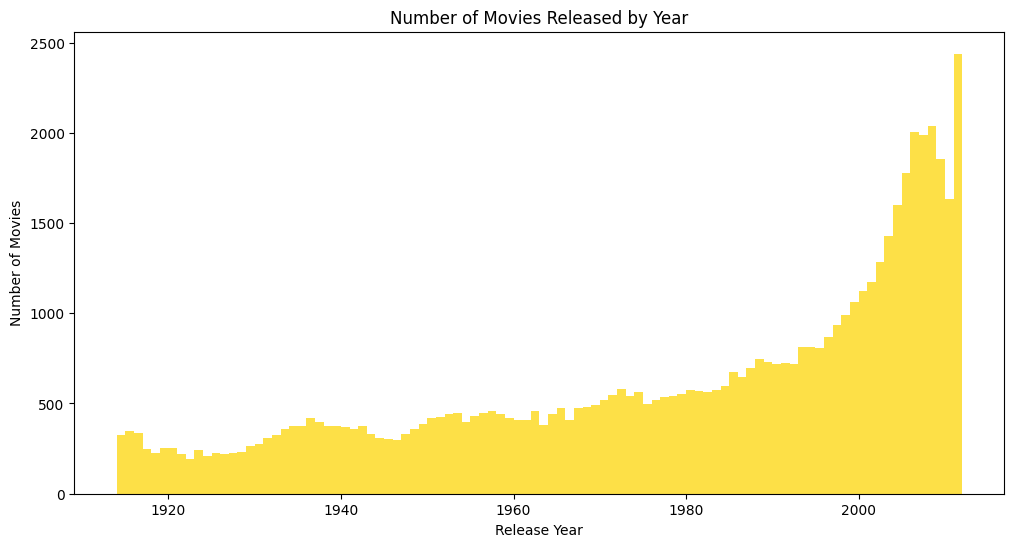

In [31]:
# plot the distribution of movies released by year
movies_per_year(movies_complete_df)

We can observe that the distribution of movies produced between 1910 until 2013 follows a heavy left-skewed distribution, with a notable increase since the 1980's. Indeed, whereas the number of movies produced present in our database barely reached 500 per year until the 1980, it impressively increased to reach about 2000 movies in the beginning of the 21th century.


# 3. Data Analysis

## A. Movie Directors

We are now diving straight into our theme by first looking at the gender distribution of movie directors.

In [57]:
# plot the distribution of genders amongst movie directors
plot_gender_distribution(movies_complete_df, 'director_gender')

**Analysis**

The number of movies in our dataset directed by a man is considerably higher than the ones directed by a woman. From this point on, we will mainly direct our analysis by comparing the result regarding the gender of the movie director in order to detect any tendancy.

## B. Female Actors / Characters

To pursue our analysis, we will focus on female representation within the movie industry. We will first look at the distribution of movie characters, and then link this data with specific features such as the age distribution, through time and space, as well as gender representation across movie genres.

### 1) Overview

In [56]:
# plot the distribution of genders amongst movie characters
plot_gender_distribution(movies_complete_df, 'actor_genders')

**Analysis**

This graph illustrates genre inequalities amongst actors. As we can see, overall only 1/3 of the actors are female.

### 2) Age Distribution

In [47]:
# pre-processing the data
female_female_percentage, female_male_percentage = process_actor_age(movies_complete_df.explode(['actor_genders', 'actor_age']), 'F')
male_female_percentage, male_male_percentage = process_actor_age(movies_complete_df.explode(['actor_genders', 'actor_age']), 'M')

In [49]:
# plot each age distribution
fig = go.Figure()
age_actors_by_dir(fig, female_female_percentage, "Female Actors (Female Directors)", COLOR_FEMALE, 'solid')
age_actors_by_dir(fig, female_male_percentage, "Male Actors (Female Directors)", COLOR_FEMALE, 'dash')
age_actors_by_dir(fig, male_female_percentage, "Female Actors (Male Directors)", COLOR_MALE, 'solid')
age_actors_by_dir(fig, male_male_percentage, "Male Actors (Male Directors)", COLOR_MALE, 'dash')
age_actors_layout(fig)

**Analysis**

This graph illustrates the inequalities regarding opportunities given to older actors. Whereas the majority of male actors are between 30 and 50 years old, with an average of 40 years old, most women actors are only between 20 and 30 years old, with an average of 33 years old. The male actors seem to have a longer career than female ones.

### 3) Female Characters in movies

In [58]:
# plot female representation in movies by director
fem_representation_by_dir(movies_complete_df)

**Analysis**

Overall, Female Directors tend to represent more female actors than Male Directors. The proportion drastically dropped until 1942, with over a fourth of the characters represented by women. It then increased and stabilized at around 30-35%, where it steadily increased reaching 36% in 2013. Although the first half of the 20th Century was more unconclusive, World War II could be a reasonable explanation for it, since the 1980s, this tendancy seems to stabilize.

### 4) Across the globe

As primary investigation, we conducted a small analysis regarding the geographical provenance of the movies of our dataset as seen in part 2. We will now pursue our analysis by studying the average female representation in movies across the globe. 

In [ ]:
# pre-processing of the data
gender_percentages_per_country = process_map_fem_char(movies_complete_df, "M")

In [ ]:
# representation of female characters in movies across the globe
map_M = map_fem_char(gender_percentages_per_country, "M")
map_F = map_fem_char(gender_percentages_per_country, "F")
# map_M.save("map_M.html")  # Save to file
# map_F.save("map_F.html")  # Save to file

**Analysis**
# TO DO AND TO RUN

### 5) Character distribution over movie genres

From our initial analysis, we obtained the following graph depicting the general tendancy of movies. From this distribution of movies by genre, we then selected the top-10 genres and looked at the gender distribution on them. 

In [17]:
# pre-processing of the data
male_genre_percentages_top10 = process_top10_genres(movies_complete_df[movies_complete_df["director_gender"] == "M"])
female_genre_percentages_top10 = process_top10_genres(movies_complete_df[movies_complete_df["director_gender"] == "F"])

In [70]:
# character gender representation across top-10 Genres
plot_top10_genres(male_genre_percentages_top10, "Male")
plot_top10_genres(female_genre_percentages_top10, "Female")

Overall, male representation is mainly represented across different movie genres. As expected, the number of female actors is overall higher if the movie director is a woman. For example, we can observe an increase of the number of female actors by 7-8% in the top-3 movie genres : Drama, Comedy and World Cinema. In both cases, the genre where women are the most represented is Romance.

In [53]:
# plot gender distribution of actors
genres_most_fem_char(movies_complete_df[movies_complete_df["director_gender"] == "M"], "Male", sort=False, title="Highest")
genres_most_fem_char(movies_complete_df[movies_complete_df["director_gender"] == "F"], "Female", sort=False, title="Highest")

genres_most_fem_char(movies_complete_df[movies_complete_df["director_gender"] == "M"], "Male", sort=True, title="Poorest")
genres_most_fem_char(movies_complete_df[movies_complete_df["director_gender"] == "F"], "Female", sort=True, title="Poorest")

**Analysis**

Interestingly, the movie genre in which female actors appear the most are related to sexuality : LGBTQ, Erotic and Adult Film and Romance, regardless of the gender of the movie director. This highlights how deeply ingrained the stereotypes of the sexualization of women are in society.

On the other side, male directors tend to have a percentage of female actors inferior to 25% when filming historical / western movies whereas female directors are more likely to cast more actresses in their movies (lowest average of 32.5% in Action movies).

## C. TV TROPES

In [72]:
filtered_tropes, genderedness_df = preprocess_tvtropes(movies_complete_df) # to do once to generate the csv file

Loaded data from data/raw/tvtropes.clusters.txt, shape: (500, 2)
Loaded data from src/data/external_data/film_tropes.csv, shape: (751594, 6)
Loaded data from src/data/external_data/genderedness_filtered.csv, shape: (20931, 9)


In [73]:
final_tropes_F = get_dominant_tropes(filtered_tropes, genderedness_df, dominant="FemaleTokens", non_dominant="MaleTokens")
print(f"Female tropes mostly represented:\n", final_tropes_F["Trope"])

Female tropes mostly represented:
 0           FinalGirl
1          BrokenBird
2          DumbBlonde
3     BrainlessBeauty
4          ValleyGirl
5    ClassyCatBurglar
Name: Trope, dtype: object


In [74]:
final_tropes_M = get_dominant_tropes(filtered_tropes, genderedness_df, dominant="MaleTokens", non_dominant="FemaleTokens")
print(f"Male tropes mostly represented:\n", final_tropes_M.head(6)["Trope"])

Male tropes mostly represented:
 0                     DirtyCop
1                  ByronicHero
2                PsychoForHire
3             HenpeckedHusband
4              MasterSwordsman
5    CorruptCorporateExecutive
Name: Trope, dtype: object


In [75]:
# pre-processing of the data
male_director_data, female_director_data = preprocessing_final_tropes(final_tropes_F, final_tropes_M)

In [ ]:
# Filter rows where 'actor_gender' contains 'F'
character_type_gender_counts = filtered_tropes.groupby(['character_type', 'actor_gender']).size().unstack(fill_value=0)
filtered_character_type_gender_counts = character_type_gender_counts[character_type_gender_counts['F'] > 0]

# ADAPTER LE DF & RUN

In [ ]:
# plot repartition of gendes for character types
gender_char_types(filtered_character_type_gender_counts)

**Analysis**

Here, we only plotted the categories that have some female characters. As expected following societal cliches, female characters are often juged based on their appearance (ex :"dumb blond") whereas more flatterous characters are predominantly males such as "byronic_hero" or "master_swodsman". Some categories are 100% female characters: chanteuse, final_girl, ophelia, prima_donna, valley_girl. Indeed, some genders word are contained in the title of the tv tropes. As for the category brainless beauty, we observe it is almost 50-50 but considering there is really less female characters, it is obvious to see that it is disproportionate.


In [ ]:
# plot trop distribution by movie director gender
plot_director_trope_pie_charts(male_director_data, female_director_data)

# MODIF COULEURS & POSITIONNEMENT TXT

**Analysis**

Interestingly, male directors tends to represent more masculin tv tropes than feminin ones, which can be simply explained by the fact that the distribution of actresses within movies produced by male directors is significantly low. In comparison, female directors tends to represent more or less equally stereotypes regarding each gender.

## D. Role of Women in movies : Bechdel Test

### 1) Primary Analysis

The Bechdel Test is a test that evalutes the role and representation attributed to actresses in movies. The four possible results are :
- 0 : there is less than two female characters in the movie
- 1 : there are two female characters in the movie
- 2 : two female characters talk to each other
- 3 : two female characters talk to each other about something else than a man

With our initial analysis, we first intend to discover if the movies of our database tend to be sexist or not and further on whether the gender of the movie director has an influence on the result of the test.

# FROM HERE HOVER TEMPLATE NOT CHECKED

In [ ]:
# pre-processing of the data
df_bechdel_corr = process_bechdel(movies_complete_df)

In [48]:
bechdel_test_ratings_by_gender(df_bechdel_corr)

**Analysis**

This graph shows the difference in success rates on the Bechdel test according to the gender of the director. We can see that, in proportion, female directors tend to produce movies that pass the Bechdel test more often than male directors.

In [ ]:
df_bechdel_corr = process_bechdel(movies_complete_df)

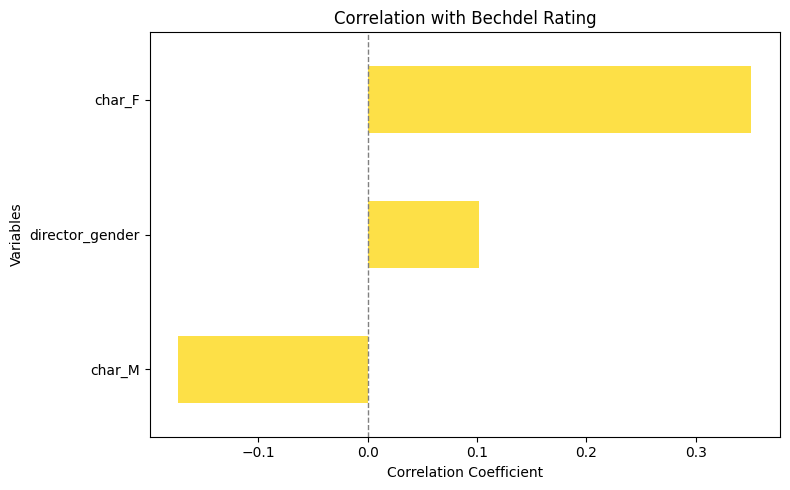

In [33]:
# plot the correlation between the bechdel test result and different features
corr_bechdel(df_bechdel_corr)

**Analysis**

From this correlation graph, we can conclude that the number of female characters in a movie has a small positive correlation with the test of the bechdel test, with a score of 0.35 approximately. This result is obvious as the Bechdel test success relies of female characters. On the other hand, the director gender and the number of male characters in a movie have a respective minor positive and negative impact on the result of the test.

# j'arrive po à modif la couleur je comprends pas pq

### 2) When linked with sentiment analysis

In [5]:
# define specific dataframe
df_plot_emotions = process_df_emotions(movies_complete_df)

In [6]:
# pre-processing of data
emotion_scores = process_emotion_scores(df_plot_emotions)

In [92]:
# plot emotions in plot summaries
graph_emotions(emotion_scores)

**Analysis**

We see that more film summaries are categorised as including anger, whereas few contain joy or surprise. For further analysis, we want to investigate the potential relationship between the emotions and the genders of the main actors.

In [7]:
# pre-processing of data
ratios_women, ratios_men = process_emotion_by_dir_gender(df_plot_emotions)

In [94]:
# plot ratio of emotions by gender
graph_ratio_emotion_by_director_gender(ratios_women, ratios_men)

**Analysis**

We see a difference in the emotions present depending on the director's gender, particularly that of sadness, which is much more represented among women directors. On the opposite, men tend to represent anger, joy and fear more. However, some emotions are represented equally, such as disgust and surprise.

In [10]:
# plot ratio of emotion by director gender
graph_ratio_emotion_radar_by_director_gender(ratios_women, ratios_men)

**Analysis**

This graph represents the same data as the previous one, but in a different form. Thanks to this radar graph, we can see that male and female directors do not represent exactly the same emotions on screen. We see marked differences in sadness, fear and anger, but surprise or disgust, for example, do not seem to depend on the director's gender.

### 3) Does your favorite movie pass the Bechdel Test ? - Logistic Regression

# EXPLICATION

In [ ]:
y_test, y_pred_test, log_reg_model, X_train = logistic_regression_for_bechdel(movies_complete_df)

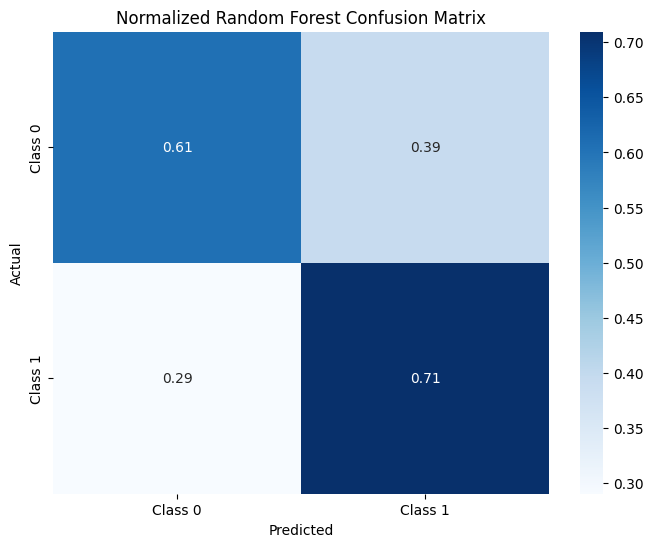

In [12]:
plot_confusion_matrix(y_test, y_pred_test)


**Analysis**

Here we have the confusion matrix of the machine learning model created to predict the success of different films in the Bechdel test. Here we see that the darker boxes correspond to true positive and true negative, which correspond to correctly classified results. We also notice that we obtain more false positives (0.39) than false negatives (0.29), which means that our model is more likely to predict that a film will pass the Bechdel test when in reality it will not. 

# TO RUN AND ANALYSIS

In [13]:
feature_importance(log_reg_model, X_train)

,Feature,Coefficient,Importance
7,char_F,1.112821,1.112821
6,char_M,-0.669825,0.669825
34,Feminist,0.405446,0.405446
100,Egypt,0.251107,0.251107
91,Serbia,-0.246478,0.246478
...,...,...,...
111,Greece,0.000000,0.000000
71,nan,0.000000,0.000000
120,Cameroon,0.000000,0.000000
106,Singapore,0.000000,0.000000


**Analysis**

Evaluating the importance of the features, we see that as we could have expected the number of female characters in the movie influences greatly the result of the Bechdel Test, that relies on the first assumption that at least two women are present. This means that if many women are present in the movie, the bechdel has more chances to be achieved. Additionally, the number of male characters negatively influences the classification. This means that if many male characters are present, then the bechdel has less chance to be achieved.
Lower in the importance, we also see that the genre Feminist can impact the classification, as well as some countries. Since the coefficients are pretty low, they do not impact as much as the two first features.

### Use of our ML model on films with no bechdel test score

In [ ]:
df_preprocessed = preprocess_before_inference(movies_complete_df)

In [12]:
df_bechdel_predictions = obtain_prediction_bechdel(df_preprocessed)

In [35]:
plot_bechdel_predictions(df_bechdel_predictions)

**Analysis**
We used our previously trained machine learning model to predict whether the remaining films in our dataset would pass the bechdel or not. We see that according to our model, which has an accuracy of around 70%, the majority of the films in our dataset do not pass the bechdel. 

In [38]:
df_plot = preprocess_bechdel_ratings_by_dirctor_gender(df_preprocessed)

In [39]:
bechdel_test_obtain_with_ml_ratings_by_gender(df_plot)

**Analysis**
Here we have the results of our bechdel success predictions according to the director's genre. We can see that there is a significant difference between female directors who do better in the Bechdel than male directors. And more female directors pass the bechdel than male directors. 

### Comparison of emotions in films that pass or fail the bechdel test

In [ ]:
# pre-processing of the data
df_bechdel_radar = preprocessing_bechdel_for_radar_graph(movies_complete_df)

In [ ]:
# plot the graph
graph_emotions_bechdel_combined(df_bechdel_radar)

# pas checké je peux pas le run

**Analysis**

Here we have two radar graphs. The first represents the average presence of the seven emotions on the graph, separated according to the director's genre, but knowing that the film has passed the bechdel test, unlike the second graph, which represents the presence of the emotions knowing that the directors have not passed the test. What's interesting is that we see that when male and female directors don't pass the Bechdel, their films tend to contain more anger, particularly among male directors. And female directors show more disgust than when they pass the bechdel, but less joy. On the other hand, when male and female directors pass the bechdel test, they show more sadness, especially the women, and the men show much more fear and anger than the women. Generally speaking, there is a real difference in the way emotions appear in films that pass the Bechdel test and those that don't, with differences within each group depending on the director's genre. 

## E. Public and Financial Recognition

### Overview

Exploring the dataset, we found some interesting numbers that concern our dataset without any prior treatment.

In [178]:
movies_complete_df.groupby('director_gender')['num_votes'].describe()

,count,mean,std,min,25%,50%,75%,max
director_gender,,,,,,,,
F,3035.0,10206.587479,39639.966169,51.0,262.0,1025.0,4227.0,745178.0
M,29137.0,21235.584274,94004.888879,51.0,371.0,1293.0,5981.0,2952726.0


By computing statistics proportional to the number of movies directed by each gender, we observe a consequent difference regarding the number of votes attributed to movie amongst genders. On average, movies directed by men will receive twice the amount of ratings compared to movies directed by women. This parameter is although not resistant against extreme values. By comparing the median, we observe a smaller difference. This reveals a presence of outliers, and more specifically popularity amongst certain movies directed by men.

In [40]:
# plot the average rating of movies by director gender
avg_rating(movies_complete_df)

The movies directed by women seem to be interestingly better rated than the ones directed by men, which demonstrates more public interest in movies directed by women.

From now on, we will keep our adapt our dataset by focusing on the Bechdel Test.

In [41]:
# pre-processing of data - "passed" & "failed" group
passed_df = movies_complete_df[movies_complete_df['bechdel_rating'] == 3]
failed_df = movies_complete_df[movies_complete_df['bechdel_rating'] <= 2]

When computing statistics regarding the gender of movie directors, we discovered that interestingly around 14,1% of the movie directors who produced a movie that passes the Bechdel Test are female whereas only 5% of the movie directors which movie failed the test are female.
This reveals that naturally women directors tend to create meaningful itneractions between women characters and break the stereotypes.

After conducting an analysis of the film genres most prevalent in the remaining categories, we found that films that did not pass the Bechdel Test were predominantly westerns, historical films, action, adventure, and silent films. The inclusion of silent films is understandable, but the presence of the other genres can be explained by gender stereotypes. Indeed, these genres often feature male protagonists, leaving female characters in passive roles or as love interests. Interactions between female characters are often scarce or non-existent, which causes the Bechdel Test to fail. Our first thought was to pursue our analysis focusing only on these genres, associated with the result of the Bechdel Test in order to explore the "extremes". However, we did not find any remarquable difference and decided to redirect our focus on the result of the Bechdel Test only.

# j'aurais enlevé la corr

In [ ]:
# By gender
for gender in movies_complete_df['director_gender'].unique():
    subset = movies_complete_df[movies_complete_df['director_gender'] == gender]
    pearson_corr, pearson_p = pearsonr(subset["average_rating"], subset["box_office_revenue"])
    spearman_corr, spearman_p = spearmanr(subset["average_rating"], subset["box_office_revenue"])
    print(f"{gender} Directors:")
    print(f"  - Pearson Correlation: {pearson_corr:.2f} with p-value:{pearson_p}")
    print(f"  - Spearman Correlation: {spearman_corr:.2f} with p-value:{spearman_p}")

### 1) Public Recognition

While keeping our dataframes focusing on the result of the Bechdel Test, we will now compare the ratings depending on the gender of the movie director. What do you think ? Will a movie directed by a woman that break stereotypes be better received by the critique than a movie filled with stereotypes ?

In [17]:
# pre-processing of the data to plot average rating by bechdel test result and by movie director gender
ratings_passed_male, ratings_passed_female = process_ratings_bechdel(passed_df)
ratings_failed_male, ratings_failed_female = process_ratings_bechdel(failed_df)

# ici modif les proportions hovering

In [20]:
# plot average rating of movies by bechdel test result and by movie director gender
avg_rating_bechdel(ratings_passed_female, ratings_failed_female, ratings_passed_male, ratings_failed_male)

**Analysis**

Interestingly, movies that fail the Bechdel test tend to be better ranked than the ones who pass the test, regardless of director gender. This statement is even stronger for female directors, for which more than 50% of the moviesfailing Bechdel received a grade greater than 7/10. 

Overall, movies that complete the Bechdel test are better ranked if they are directed by a man whereas female director giving visibility to actresses tend to be more persecuted by the critique.

We can now wonder whether such difference is also depicted in the economical success of the movie ?

### 2) Financial Success

Now focusing only on the success of movies depending on their Bechdel test, we first intended to uncover a tendancy regarding the box office revenue. Will a movie that breaks stereotypes be rewarded ?

In [27]:
# pre-processing of the data
revenue_passed_male, revenue_passed_female = process_revenue_bechdel(passed_df)
revenue_failed_male, revenue_failed_female = process_revenue_bechdel(failed_df)

In [28]:
# plot revenues depending on bechdel test result by director gender
revenue_bechdel(revenue_passed_male, revenue_passed_female, revenue_failed_male, revenue_failed_female)

**Analysis**

It seems that independently of the movie director gender, movies passing the Bechdel Test exhibit a broader and higher revenue range, on average slightly even more when directed by women. The difference is even stronger when focusing solely on women directors. Indeed, meaningful interaction between women approximately increases the box office revenue from 27 to 47 million dollars.


### 3) Relation between Public and Financial Recognition

In [21]:
# pre-processing of the dataset containing the movies that passed the Bechdel test, in oder to exclude na values
passed_df = passed_df.dropna(subset=['movie_budget', 'box_office_revenue', 'average_rating'])

In [23]:
# plot the relation between average rating, box office revenue, movie budgetand director gender within movies that passed the bechdel test
# the size of the scattered dots corresponds to the movie budgets
success_bechdel(passed_df)

**Analysis**

Focusing on female directors, the average rating of a movie does not seem to correlate with the box office revenue as the revenue seems to oscillate between 0 and 500 millions dollars independantly of the rating. Although, we can notice that movies rated less than 4.5 / 10 tend to have a smaller revenue.

Focusing on male directors, the range of box office revenue seems to divide into 3 groups seems to extend when better received by the critique. There is thus not a clear correlation between the two variables, although we can affirm that movies directed by men tends to obtain a bigger financial revenue.

Moreover, not only do female directors tend to earn little revenu compared to male directors no matter the popularity of the movie, less than 200 million for the majority of movies, but the tendancy is NOT the case in the opposite way. Indeed, movies directed by men seem to be rewarded economically when appreciated by the critique as they can bring billions of dollars, but also have the most important financial means.

Regarding the movie budget, it often exceeds 200 million when directed by men whereas barely reaches 80 million for the luckier movies directed by female, which once again displays  financial success disparities amongst genders.